In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import cv2
import mediapipe as mp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import csv
from tqdm import tqdm
import shutil
from collections import deque
from scipy.stats import stats
import time

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [5]:
class EnhancedGestureDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        Initialize the dataset with enhanced feature extraction.
        
        Args:
            data_dir: Directory containing processed .npy files
            transform: Optional data augmentation transforms
        """
        self.file_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".npy")]
        self.transform = transform
        
        # Create label mapping
        label_set = set()
        for f in self.file_paths:
            label = os.path.basename(f).split("_")[0]
            label_set.add(label)
        
        self.label2idx = {label: idx for idx, label in enumerate(sorted(label_set))}
        self.idx2label = {idx: label for label, idx in self.label2idx.items()}
        
        print(f"Found {len(self.file_paths)} samples with {len(label_set)} classes")
        print(f"Label mapping: {self.label2idx}")
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        
        # Load the sequence
        try:
            sequence = np.load(file_path)
            
            # Handle potential inconsistent shapes
            if isinstance(sequence, np.ndarray) and sequence.dtype == 'object':
                print(f"Warning: Object array found in {file_path}, skipping")
                # Return a zero-filled sequence as placeholder
                sequence = np.zeros((30, 354), dtype=np.float32)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            sequence = np.zeros((30, 354), dtype=np.float32)
        
        # Apply transformations if any
        if self.transform:
            sequence = self.transform(sequence)
        
        # Convert to tensor
        sequence = torch.tensor(sequence, dtype=torch.float32)
        
        # Extract label from filename
        label_str = os.path.basename(file_path).split("_")[0]
        label = self.label2idx[label_str]
        label = torch.tensor(label, dtype=torch.long)
        
        return sequence, label

In [6]:
class AttentionModule(nn.Module):
    """Self-attention module for temporal feature refinement"""
    def __init__(self, hidden_size):
        super(AttentionModule, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1)
        )
        
    def forward(self, lstm_output):
        # lstm_output shape: (batch, seq_len, hidden_size)
        attn_weights = self.attention(lstm_output)  # (batch, seq_len, 1)
        attn_weights = F.softmax(attn_weights, dim=1)  # Apply softmax over sequence dimension
        
        # Apply attention weights
        context = torch.sum(attn_weights * lstm_output, dim=1)  # (batch, hidden_size)
        return context, attn_weights

class ImprovedGestureLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.5, bidirectional=True):
        """
        Enhanced LSTM model with attention and residual connections.
        
        Args:
            input_size: Number of features per frame
            hidden_size: LSTM hidden size
            num_layers: Number of LSTM layers
            num_classes: Number of output classes
            dropout: Dropout rate
            bidirectional: Whether to use bidirectional LSTM
        """
        super(ImprovedGestureLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.direction_factor = 2 if bidirectional else 1
        
        # Feature embedding layer
        self.embedding = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout/2)
        )
        
        # Main LSTM layers
        self.lstm = nn.LSTM(
            hidden_size, 
            hidden_size, 
            num_layers, 
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        
        # Attention mechanism 
        self.attention = AttentionModule(hidden_size * self.direction_factor)
        
        # Classification layers
        self.fc1 = nn.Linear(hidden_size * self.direction_factor, hidden_size)
        self.layernorm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        batch_size, seq_len, _ = x.size()
        
        # Embed features
        x = self.embedding(x)  # (batch, seq_len, hidden_size)
        
        # LSTM forward pass
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, hidden_size*direction_factor)
        
        # Apply attention
        context, attention_weights = self.attention(lstm_out)
        
        # Classification layers with residual connection
        out = self.fc1(context)
        out = self.layernorm(out)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out, attention_weights

In [4]:
def evaluate_model(model, test_loader, criterion, device, idx2label, model_name, graph_dir):
    """
    Evaluate the model on the test set and generate confusion matrix.
    
    Args:
        model: Trained model
        test_loader: DataLoader for test set
        criterion: Loss function
        device: Device to run evaluation on
        idx2label: Mapping from indices to labels
        model_name: Name for saved visualization files
        graph_dir: Directory to save graphs
    """
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for sequences, labels in tqdm(test_loader, desc="Testing"):
            sequences, labels = sequences.to(device), labels.to(device)
            outputs, _ = model(sequences)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item() * sequences.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = test_loss / total
    test_acc = (correct / total) * 100
    
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[idx2label[i] for i in range(len(idx2label))],
                yticklabels=[idx2label[i] for i in range(len(idx2label))])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(graph_dir, f"{model_name}_confusion_matrix.png"))
    
    # Generate classification report
    class_names = [idx2label[i] for i in range(len(idx2label))]
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("Classification Report:")
    print(report)
    
    # Save report to file
    with open(os.path.join(graph_dir, f"{model_name}_classification_report.txt"), 'w') as f:
        f.write(report)

In [5]:
def train_model(data_dir, model_name="improved_model", num_epochs=100, batch_size=32, 
                learning_rate=0.001, hidden_size=128, num_layers=2, dropout=0.5, 
                weight_decay=1e-5, patience=10, bidirectional=True):
    """
    Train the model with improved techniques:
    - Learning rate scheduling
    - Early stopping
    - Gradient clipping
    - TensorBoard logging
    
    Args:
        data_dir: Directory containing the processed data
        model_name: Name for saved model files
        num_epochs: Maximum number of training epochs
        batch_size: Batch size for training
        learning_rate: Initial learning rate
        hidden_size: Size of LSTM hidden layers
        num_layers: Number of LSTM layers
        dropout: Dropout rate for regularization
        weight_decay: L2 regularization factor
        patience: Early stopping patience (epochs)
        bidirectional: Whether to use bidirectional LSTM
    
    Returns:
        Trained model and training history
    """
    # Create output directories
    model_dir = os.path.join("..", "models")
    log_dir = os.path.join("..", "logs")
    graph_dir = os.path.join("..", "graphs")
    
    for directory in [model_dir, log_dir, graph_dir]:
        os.makedirs(directory, exist_ok=True)
    
    # Create dataset and loaders
    dataset = EnhancedGestureDataset(data_dir)
    
    # Split into train/val/test (70/15/15)
    total_size = len(dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size]
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Get input dimensions from a sample
    sample_seq, _ = dataset[0]
    input_size = sample_seq.shape[1]
    num_classes = len(dataset.label2idx)
    
    # Initialize model
    model = ImprovedGestureLSTM(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        num_classes=num_classes,
        dropout=dropout,
        bidirectional=bidirectional
    )
    
    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Initialize loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=learning_rate,
        weight_decay=weight_decay
    )
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5, 
        patience=5, 
        verbose=True
    )
    
    # Initialize training history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'lr': []
    }
    
    # Initialize early stopping variables
    best_val_loss = float('inf')
    best_epoch = 0
    
    # Start training
    print(f"Training on {device} with {train_size} training, {val_size} validation, {test_size} test samples")
    
    # Create log file
    log_file = os.path.join(log_dir, f"{model_name}_training_log.csv")
    with open(log_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc", "lr"])
    
    for epoch in range(1, num_epochs + 1):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]")
        for sequences, labels in pbar:
            sequences, labels = sequences.to(device), labels.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs, _ = model(sequences)
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Update weights
            optimizer.step()
            
            # Track metrics
            train_loss += loss.item() * sequences.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            pbar.set_postfix({"loss": loss.item(), "acc": correct/total})
        
        train_loss = train_loss / total
        train_acc = (correct / total) * 100
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for sequences, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} [Val]"):
                sequences, labels = sequences.to(device), labels.to(device)
                outputs, _ = model(sequences)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * sequences.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_loss = val_loss / total_val
        val_acc = (correct_val / total_val) * 100
        
        # Update learning rate
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Store metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)
        
        # Print progress
        print(f"Epoch [{epoch}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}% | "
              f"LR: {current_lr:.6f}")
        
        # Save metrics to CSV
        with open(log_file, mode="a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([epoch, train_loss, train_acc, val_loss, val_acc, current_lr])
        
        # Check if this is the best model so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            
            # Save the model
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc,
                'train_loss': train_loss,
                'train_acc': train_acc,
                'label2idx': dataset.label2idx,
                'idx2label': dataset.idx2label
            }
            
            model_path = os.path.join(model_dir, f"{model_name}_best.pt")
            torch.save(checkpoint, model_path)
            print(f"Model improved. Saved checkpoint to {model_path}")
        
        # Early stopping check
        if epoch - best_epoch >= patience:
            print(f"Early stopping triggered after {epoch} epochs!")
            break
    
    # Save final model
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_loss': val_loss,
        'val_acc': val_acc,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'label2idx': dataset.label2idx,
        'idx2label': dataset.idx2label
    }
    
    model_path = os.path.join(model_dir, f"{model_name}_final.pt")
    torch.save(checkpoint, model_path)
    
    # Plot training curves
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(graph_dir, f"{model_name}_training_curves.png"))
    
    # Evaluate on test set
    evaluate_model(model, test_loader, criterion, device, dataset.idx2label, model_name, graph_dir)
    
    print("Training complete.")
    return model, history


Found 1260 samples with 7 classes
Label mapping: {'bye': 0, 'hello': 1, 'namaste': 2, 'practice': 3, 'sorry': 4, 'thankyou': 5, 'welcome': 6}


c:\Users\beana\OneDrive - 123\Desktop\Final-Year-Project\lstm-pyt\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training on cuda with 882 training, 189 validation, 189 test samples


Epoch 1/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 102.88it/s]


Epoch [1/100] - Train Loss: 1.3231, Train Acc: 46.03% | Val Loss: 0.8520, Val Acc: 67.20% | LR: 0.001000
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 2/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 116.46it/s]


Epoch [2/100] - Train Loss: 0.6174, Train Acc: 79.93% | Val Loss: 0.3517, Val Acc: 88.89% | LR: 0.001000
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 3/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 103.00it/s]


Epoch [3/100] - Train Loss: 0.2928, Train Acc: 93.20% | Val Loss: 0.1630, Val Acc: 94.71% | LR: 0.001000
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 4/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 107.14it/s]


Epoch [4/100] - Train Loss: 0.2773, Train Acc: 93.20% | Val Loss: 0.0663, Val Acc: 98.41% | LR: 0.001000
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 5/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 108.06it/s]


Epoch [5/100] - Train Loss: 0.1408, Train Acc: 97.17% | Val Loss: 0.0861, Val Acc: 97.88% | LR: 0.001000


Epoch 6/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 106.20it/s]


Epoch [6/100] - Train Loss: 0.0926, Train Acc: 97.96% | Val Loss: 0.0987, Val Acc: 97.88% | LR: 0.001000


Epoch 7/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 113.94it/s]


Epoch [7/100] - Train Loss: 0.1461, Train Acc: 96.49% | Val Loss: 0.1643, Val Acc: 94.18% | LR: 0.001000


Epoch 8/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 77.59it/s]


Epoch [8/100] - Train Loss: 0.1059, Train Acc: 98.07% | Val Loss: 0.0402, Val Acc: 98.41% | LR: 0.001000
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 9/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 89.53it/s]


Epoch [9/100] - Train Loss: 0.1014, Train Acc: 97.96% | Val Loss: 0.0046, Val Acc: 100.00% | LR: 0.001000
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 10/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 104.84it/s]


Epoch [10/100] - Train Loss: 0.1026, Train Acc: 97.85% | Val Loss: 0.1417, Val Acc: 95.77% | LR: 0.001000


Epoch 11/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 45.36it/s]


Epoch [11/100] - Train Loss: 0.1095, Train Acc: 97.85% | Val Loss: 0.2707, Val Acc: 94.18% | LR: 0.001000


Epoch 12/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 23.69it/s]


Epoch [12/100] - Train Loss: 0.0452, Train Acc: 98.87% | Val Loss: 0.2289, Val Acc: 95.77% | LR: 0.001000


Epoch 13/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 56.73it/s]


Epoch [13/100] - Train Loss: 0.1016, Train Acc: 97.73% | Val Loss: 0.2879, Val Acc: 94.71% | LR: 0.001000


Epoch 14/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 27.33it/s]


Epoch [14/100] - Train Loss: 0.0716, Train Acc: 98.87% | Val Loss: 0.0017, Val Acc: 100.00% | LR: 0.001000
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 15/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 76.92it/s]


Epoch [15/100] - Train Loss: 0.0363, Train Acc: 99.21% | Val Loss: 0.0009, Val Acc: 100.00% | LR: 0.001000
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 16/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 46.20it/s]


Epoch [16/100] - Train Loss: 0.0164, Train Acc: 99.77% | Val Loss: 0.0030, Val Acc: 100.00% | LR: 0.001000


Epoch 17/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 75.70it/s]


Epoch [17/100] - Train Loss: 0.0327, Train Acc: 99.21% | Val Loss: 0.0017, Val Acc: 100.00% | LR: 0.001000


Epoch 18/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 77.13it/s]


Epoch [18/100] - Train Loss: 0.0226, Train Acc: 99.21% | Val Loss: 0.0007, Val Acc: 100.00% | LR: 0.001000
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 19/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 75.35it/s]


Epoch [19/100] - Train Loss: 0.0357, Train Acc: 99.43% | Val Loss: 0.0003, Val Acc: 100.00% | LR: 0.001000
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 20/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 62.56it/s]


Epoch [20/100] - Train Loss: 0.0367, Train Acc: 99.32% | Val Loss: 0.0004, Val Acc: 100.00% | LR: 0.001000


Epoch 21/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 62.64it/s]


Epoch [21/100] - Train Loss: 0.0318, Train Acc: 99.55% | Val Loss: 0.0003, Val Acc: 100.00% | LR: 0.001000
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 22/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 54.89it/s]


Epoch [22/100] - Train Loss: 0.0152, Train Acc: 99.55% | Val Loss: 0.0280, Val Acc: 99.47% | LR: 0.001000


Epoch 23/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 88.86it/s]


Epoch [23/100] - Train Loss: 0.0923, Train Acc: 98.30% | Val Loss: 0.0659, Val Acc: 97.35% | LR: 0.001000


Epoch 24/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 83.51it/s]


Epoch [24/100] - Train Loss: 0.0898, Train Acc: 98.19% | Val Loss: 0.0009, Val Acc: 100.00% | LR: 0.001000


Epoch 25/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 100.72it/s]


Epoch [25/100] - Train Loss: 0.0439, Train Acc: 99.32% | Val Loss: 0.0922, Val Acc: 97.35% | LR: 0.001000


Epoch 26/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 66.92it/s]


Epoch [26/100] - Train Loss: 0.1785, Train Acc: 96.83% | Val Loss: 0.0588, Val Acc: 97.88% | LR: 0.001000


Epoch 27/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 52.24it/s]


Epoch [27/100] - Train Loss: 0.1979, Train Acc: 96.03% | Val Loss: 0.1584, Val Acc: 97.35% | LR: 0.000500


Epoch 28/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 69.72it/s]


Epoch [28/100] - Train Loss: 0.0498, Train Acc: 99.21% | Val Loss: 0.0006, Val Acc: 100.00% | LR: 0.000500


Epoch 29/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 48.19it/s]


Epoch [29/100] - Train Loss: 0.0034, Train Acc: 100.00% | Val Loss: 0.0003, Val Acc: 100.00% | LR: 0.000500


Epoch 30/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 64.68it/s]


Epoch [30/100] - Train Loss: 0.0028, Train Acc: 100.00% | Val Loss: 0.0002, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 31/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 35.23it/s]


Epoch [31/100] - Train Loss: 0.0019, Train Acc: 100.00% | Val Loss: 0.0002, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 32/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 73.80it/s]


Epoch [32/100] - Train Loss: 0.0031, Train Acc: 100.00% | Val Loss: 0.0002, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 33/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 64.91it/s]


Epoch [33/100] - Train Loss: 0.0019, Train Acc: 100.00% | Val Loss: 0.0001, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 34/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 114.07it/s]


Epoch [34/100] - Train Loss: 0.0016, Train Acc: 100.00% | Val Loss: 0.0001, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 35/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 112.05it/s]


Epoch [35/100] - Train Loss: 0.0012, Train Acc: 100.00% | Val Loss: 0.0001, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 36/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 111.07it/s]


Epoch [36/100] - Train Loss: 0.0013, Train Acc: 100.00% | Val Loss: 0.0001, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 37/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 96.38it/s]


Epoch [37/100] - Train Loss: 0.0016, Train Acc: 100.00% | Val Loss: 0.0001, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 38/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 22.92it/s]


Epoch [38/100] - Train Loss: 0.0019, Train Acc: 100.00% | Val Loss: 0.0001, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 39/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 40.01it/s]


Epoch [39/100] - Train Loss: 0.0011, Train Acc: 100.00% | Val Loss: 0.0001, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 40/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 89.87it/s]


Epoch [40/100] - Train Loss: 0.0010, Train Acc: 100.00% | Val Loss: 0.0001, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 41/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 116.15it/s]


Epoch [41/100] - Train Loss: 0.0009, Train Acc: 100.00% | Val Loss: 0.0001, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 42/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 93.36it/s]


Epoch [42/100] - Train Loss: 0.0011, Train Acc: 100.00% | Val Loss: 0.0001, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 43/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 103.10it/s]


Epoch [43/100] - Train Loss: 0.0007, Train Acc: 100.00% | Val Loss: 0.0001, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 44/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 31.50it/s]


Epoch [44/100] - Train Loss: 0.0008, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 45/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 97.02it/s]


Epoch [45/100] - Train Loss: 0.0010, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 46/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 20.79it/s]


Epoch [46/100] - Train Loss: 0.0007, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 47/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 71.86it/s]


Epoch [47/100] - Train Loss: 0.0010, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 48/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 19.66it/s]


Epoch [48/100] - Train Loss: 0.0010, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 49/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 43.87it/s]


Epoch [49/100] - Train Loss: 0.0010, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 50/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 23.26it/s]


Epoch [50/100] - Train Loss: 0.0007, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 51/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 31.52it/s]


Epoch [51/100] - Train Loss: 0.0008, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 52/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 24.78it/s]


Epoch [52/100] - Train Loss: 0.0008, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 53/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 39.56it/s]


Epoch [53/100] - Train Loss: 0.0007, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 54/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 36.82it/s]


Epoch [54/100] - Train Loss: 0.0006, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 55/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 75.86it/s]


Epoch [55/100] - Train Loss: 0.0007, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 56/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 25.62it/s]


Epoch [56/100] - Train Loss: 0.0008, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 57/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 33.61it/s]


Epoch [57/100] - Train Loss: 0.0005, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 58/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 88.43it/s]


Epoch [58/100] - Train Loss: 0.0005, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 59/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 69.84it/s]


Epoch [59/100] - Train Loss: 0.0007, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 60/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 58.22it/s]


Epoch [60/100] - Train Loss: 0.0005, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 61/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 55.20it/s]


Epoch [61/100] - Train Loss: 0.0006, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 62/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 48.34it/s]


Epoch [62/100] - Train Loss: 0.0005, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 63/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 62.01it/s]


Epoch [63/100] - Train Loss: 0.0006, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 64/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 91.28it/s]


Epoch [64/100] - Train Loss: 0.0005, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 65/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 106.94it/s]


Epoch [65/100] - Train Loss: 0.0004, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 66/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 82.17it/s]


Epoch [66/100] - Train Loss: 0.0005, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 67/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 98.12it/s]


Epoch [67/100] - Train Loss: 0.0004, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 68/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 64.80it/s]


Epoch [68/100] - Train Loss: 0.0004, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 69/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 31.56it/s]


Epoch [69/100] - Train Loss: 0.0006, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 70/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 30.06it/s]


Epoch [70/100] - Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 71/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 81.98it/s]


Epoch [71/100] - Train Loss: 0.0006, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 72/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 48.58it/s]


Epoch [72/100] - Train Loss: 0.0005, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 73/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 55.23it/s]


Epoch [73/100] - Train Loss: 0.0004, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 74/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 33.26it/s]


Epoch [74/100] - Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 75/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 31.32it/s]


Epoch [75/100] - Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 76/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 43.55it/s]


Epoch [76/100] - Train Loss: 0.0005, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 77/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 36.74it/s]


Epoch [77/100] - Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 78/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 81.55it/s]


Epoch [78/100] - Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 79/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 71.74it/s]


Epoch [79/100] - Train Loss: 0.0004, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 80/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 40.43it/s]


Epoch [80/100] - Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 81/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 91.75it/s]


Epoch [81/100] - Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 82/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 33.65it/s]


Epoch [82/100] - Train Loss: 0.0005, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 83/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 75.99it/s]


Epoch [83/100] - Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 84/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 85.09it/s]


Epoch [84/100] - Train Loss: 0.0004, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 85/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 92.19it/s]


Epoch [85/100] - Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 86/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 88.75it/s]


Epoch [86/100] - Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 87/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 32.86it/s]


Epoch [87/100] - Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 88/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 107.19it/s]


Epoch [88/100] - Train Loss: 0.0004, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 89/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 105.81it/s]


Epoch [89/100] - Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 90/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 54.00it/s]


Epoch [90/100] - Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 91/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 81.13it/s]


Epoch [91/100] - Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 92/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 51.43it/s]


Epoch [92/100] - Train Loss: 0.0004, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 93/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 98.97it/s]


Epoch [93/100] - Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 94/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 89.62it/s]


Epoch [94/100] - Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 95/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 108.07it/s]


Epoch [95/100] - Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 96/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 52.24it/s]


Epoch [96/100] - Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 97/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 93.86it/s]


Epoch [97/100] - Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 98/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 94.89it/s]


Epoch [98/100] - Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 99/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 82.74it/s]


Epoch [99/100] - Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Epoch 100/100 [Val]: 100%|██████████| 6/6 [00:00<00:00, 99.15it/s]


Epoch [100/100] - Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00% | LR: 0.000500
Model improved. Saved checkpoint to ..\models\ISL_holistic_best.pt


Testing: 100%|██████████| 6/6 [00:00<00:00, 101.76it/s]


Test Loss: 0.0000, Test Accuracy: 100.00%
Classification Report:
              precision    recall  f1-score   support

         bye       1.00      1.00      1.00        26
       hello       1.00      1.00      1.00        29
     namaste       1.00      1.00      1.00        27
    practice       1.00      1.00      1.00        27
       sorry       1.00      1.00      1.00        26
    thankyou       1.00      1.00      1.00        25
     welcome       1.00      1.00      1.00        29

    accuracy                           1.00       189
   macro avg       1.00      1.00      1.00       189
weighted avg       1.00      1.00      1.00       189

Training complete.


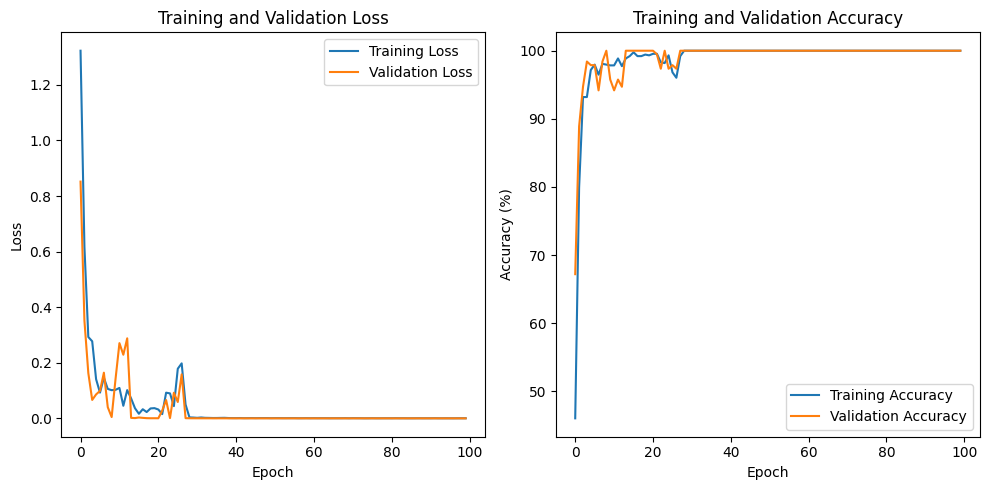

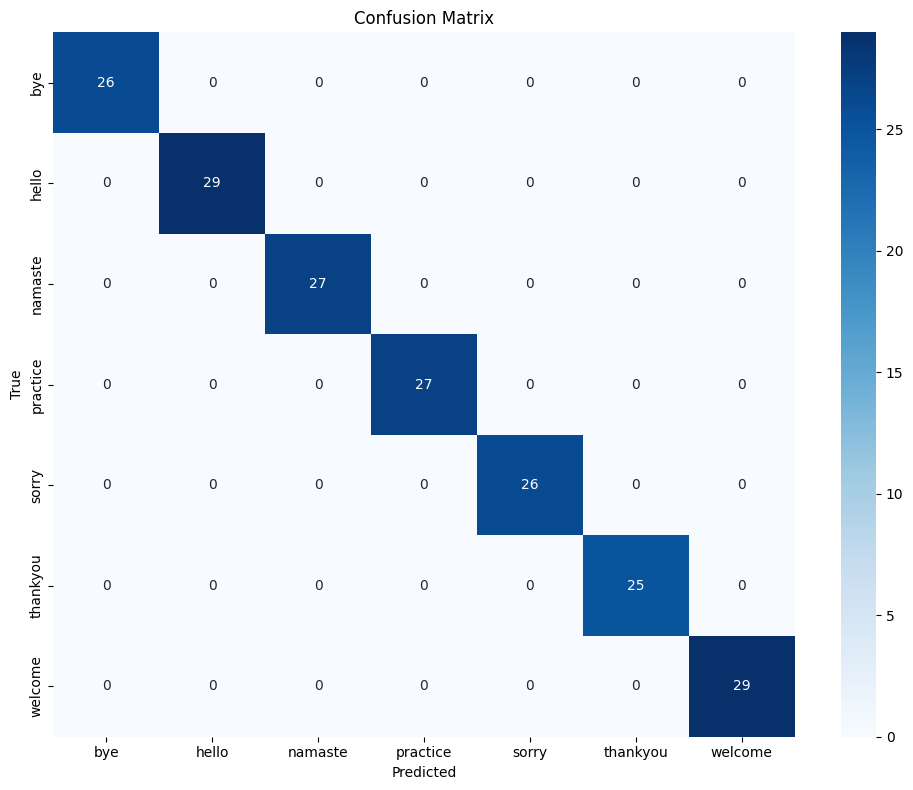

In [6]:
# Define paths and run training
DATA_DIR = os.path.join("..", "data", "processed")

# Train the improved model with default parameters
model, history = train_model(
    data_dir=DATA_DIR,
    model_name="ISL_holistic",
    num_epochs=100,
    batch_size=32,
    learning_rate=0.001,
    hidden_size=128,
    num_layers=2,
    dropout=0.5,
    weight_decay=1e-5,
    patience=10
)

In [7]:
# Visualize attention weights for a sample
def visualize_attention(model, dataset, sample_idx=0, save_path=None):
    """
    Visualize the attention weights for a sample.
    Shows which frames the model focuses on most for classification.
    """
    model.eval()
    device = next(model.parameters()).device
    
    # Get a sample
    sequence, label = dataset[sample_idx]
    true_label = dataset.idx2label[label.item()]
    
    # Add batch dimension
    sequence = sequence.unsqueeze(0).to(device)
    
    # Get outputs and attention weights
    with torch.no_grad():
        outputs, attention_weights = model(sequence)
        predicted = torch.argmax(outputs, dim=1).item()
        predicted_label = dataset.idx2label[predicted]
    
    # Convert attention weights to numpy
    attention_weights = attention_weights.squeeze().cpu().numpy()
    
    # Plot attention weights
    plt.figure(figsize=(12, 4))
    plt.bar(range(len(attention_weights)), attention_weights)
    plt.xlabel('Frame')
    plt.ylabel('Attention Weight')
    plt.title(f'Attention Weights - True: {true_label}, Predicted: {predicted_label}')
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()
    
    return attention_weights

# Load best model for analysis
def load_model_for_analysis(model_path):
    checkpoint = torch.load(model_path, map_location='cpu')
    label2idx = checkpoint['label2idx']
    idx2label = checkpoint['idx2label']
    
    # Create model with same architecture
    input_size = next(iter(checkpoint['model_state_dict'].items()))[1].shape[1]
    model = ImprovedGestureLSTM(
        input_size=input_size,
        hidden_size=128,
        num_layers=2,
        num_classes=len(idx2label)
    )
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model, label2idx, idx2label

# Example usage

In [10]:
def create_test_dataset():
    """
    Create a test dataset from a portion of your processed data.
    Use this if you don't have a separate test directory.
    """
    processed_dir = "../data/processed"
    test_dir = "../data/test"
    os.makedirs(test_dir, exist_ok=True)
    
    # Get all unique gesture types
    all_files = os.listdir(processed_dir)
    gesture_types = set()
    for file in all_files:
        if file.endswith('.npy'):
            gesture = file.split('_')[0]
            gesture_types.add(gesture)
    
    # Copy a few examples of each gesture to the test directory
    for gesture in gesture_types:
        gesture_files = [f for f in all_files if f.startswith(gesture) and not f.endswith(('noise1.npy', 'noise2.npy', 'warp1.npy', 'warp2.npy', 'shift1.npy'))]
        
        # Take at most 3 files per gesture
        test_files = gesture_files[:3]
        
        for file in test_files:
            src = os.path.join(processed_dir, file)
            dst = os.path.join(test_dir, file)
            shutil.copy(src, dst)
            
    print(f"Created test dataset with examples from {len(gesture_types)} gesture types")
    return test_dir


Created test dataset with examples from 7 gesture types
Found 21 samples with 7 classes
Label mapping: {'bye': 0, 'hello': 1, 'namaste': 2, 'practice': 3, 'sorry': 4, 'thankyou': 5, 'welcome': 6}


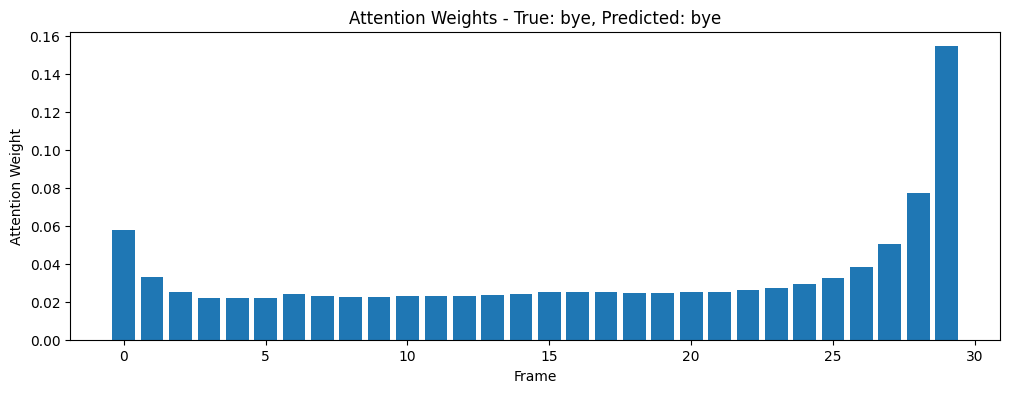

array([0.0576335 , 0.03307764, 0.02495308, 0.02207001, 0.02169143,
       0.02195263, 0.02427531, 0.02322024, 0.02257195, 0.0225742 ,
       0.02279165, 0.02284871, 0.02307507, 0.02367374, 0.02429726,
       0.02516596, 0.025012  , 0.02485233, 0.02471397, 0.02469216,
       0.02494613, 0.0252187 , 0.025933  , 0.0271381 , 0.02913444,
       0.03233384, 0.03826688, 0.05042625, 0.07717766, 0.15428206],
      dtype=float32)

In [11]:
create_test_dataset()
model, label2idx, idx2label = load_model_for_analysis(os.path.join("..", "models", "ISL_holistic_best.pt"))
test_dataset = EnhancedGestureDataset(os.path.join("..", "data", "test"))
visualize_attention(model, test_dataset, sample_idx=0, save_path=os.path.join("..", "graphs", "attention_weights.png"))

In [7]:
class RealTimeSignLanguageDetection:
    def __init__(self, model_path="../models/ISL_holistic_best.pt", sequence_length=30, threshold=0.7):
        """
        Initialize the real-time sign language detection system.
        
        Args:
            model_path: Path to the saved model checkpoint
            sequence_length: Length of the sequence to be fed to the model
            threshold: Confidence threshold for predictions
        """
        # Set device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        # Load model
        self.load_model(model_path)
        
        # Initialize MediaPipe
        self.mp_holistic = mp.solutions.holistic
        self.mp_drawing = mp.solutions.drawing_utils
        self.mp_drawing_styles = mp.solutions.drawing_styles
        self.holistic = self.mp_holistic.Holistic(
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        )
        
        # Initialize sequence parameters
        self.sequence_length = sequence_length
        self.threshold = threshold
        self.sequence_buffer = []
        
        # For prediction smoothing
        self.prediction_history = deque(maxlen=5)
        
        # For feature calculation
        self.previous_result = None
        self.previous_results_buffer = []
        
        # For FPS calculation
        self.fps_counter = 0
        self.fps_start_time = time.time()
        self.fps = 0
        
    def load_model(self, model_path):
        """Load the trained model from checkpoint"""
        try:
            self.checkpoint = torch.load(model_path, map_location=self.device)
            
            # Get label mapping
            self.label2idx = self.checkpoint['label2idx']
            self.idx2label = self.checkpoint['idx2label']
            
            # Create model
            input_size = 354  # Match your training feature dimension
            hidden_size = 128
            num_layers = 2
            num_classes = len(self.idx2label)
            
            self.model = ImprovedGestureLSTM(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                num_classes=num_classes
            )
            
            # Load model weights
            self.model.load_state_dict(self.checkpoint['model_state_dict'])
            self.model.to(self.device)
            self.model.eval()
            
            print(f"Model loaded with {num_classes} classes: {list(self.idx2label.values())}")
            
        except Exception as e:
            print(f"Error loading model: {e}")
            raise

    def extract_keypoints(self, results):
        """
        Extract keypoints from MediaPipe results in the same format used during training.
        """
        # Extract left hand landmarks
        lh = np.zeros(63) if results.left_hand_landmarks is None else \
             np.array([[lm.x, lm.y, lm.z] for lm in results.left_hand_landmarks.landmark]).flatten()
        
        # Extract right hand landmarks
        rh = np.zeros(63) if results.right_hand_landmarks is None else \
             np.array([[lm.x, lm.y, lm.z] for lm in results.right_hand_landmarks.landmark]).flatten()
        
        # Extract pose landmarks (upper body only)
        upper_body_indices = [0, 11, 12, 13, 14, 15, 16, 23, 24]
        pose = np.zeros(len(upper_body_indices) * 3)
        
        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark
            for i, idx in enumerate(upper_body_indices):
                if idx < len(landmarks):
                    pose[i*3:(i*3)+3] = [landmarks[idx].x, landmarks[idx].y, landmarks[idx].z]
        
        # Calculate relative positions
        relative_features = []
        
        if results.pose_landmarks and (results.left_hand_landmarks or results.right_hand_landmarks):
            # Reference points (shoulders)
            left_shoulder = np.array([landmarks[11].x, landmarks[11].y, landmarks[11].z]) if 11 < len(landmarks) else np.zeros(3)
            right_shoulder = np.array([landmarks[12].x, landmarks[12].y, landmarks[12].z]) if 12 < len(landmarks) else np.zeros(3)
            
            # Hand center points (if detected)
            if results.left_hand_landmarks:
                left_hand_center = np.mean(np.array([[lm.x, lm.y, lm.z] for lm in results.left_hand_landmarks.landmark]), axis=0)
                relative_features.extend(left_hand_center - left_shoulder)
            else:
                relative_features.extend(np.zeros(3))
            
            if results.right_hand_landmarks:
                right_hand_center = np.mean(np.array([[lm.x, lm.y, lm.z] for lm in results.right_hand_landmarks.landmark]), axis=0)
                relative_features.extend(right_hand_center - right_shoulder)
            else:
                relative_features.extend(np.zeros(3))
                
            # Distance between hands (if both detected)
            if results.left_hand_landmarks and results.right_hand_landmarks:
                hand_distance = right_hand_center - left_hand_center
                relative_features.extend(hand_distance)
            else:
                relative_features.extend(np.zeros(3))
        else:
            # Add placeholder zeros if landmarks aren't detected
            relative_features = np.zeros(9)
        
        # Base features
        base_features = np.concatenate([lh, rh, pose, relative_features])
        
        # Calculate velocity features if we have a previous frame
        if self.previous_result is not None:
            previous_features = self.extract_base_keypoints(self.previous_result)
            velocity_features = base_features - previous_features
        else:
            velocity_features = np.zeros_like(base_features)
        
        # Extract hand shape dynamics
        shape_features = self.extract_hand_shape_features(results)
        
        # Additional features used in training - placeholders to match dimensions
        additional_features = np.zeros(354 - len(base_features) - len(velocity_features) - len(shape_features))
        
        # Combine all features
        features = np.concatenate([
            base_features,
            velocity_features,
            shape_features,
            additional_features
        ])
        
        # Update previous result for next frame
        self.previous_result = results
        
        # Ensure exactly 354 dimensions
        assert features.shape[0] == 354, f"Feature dimension mismatch: {features.shape[0]} != 354"
        
        return features
    
    def extract_base_keypoints(self, results):
        """Extract base keypoints for velocity calculation"""
        # Extract left hand landmarks
        lh = np.zeros(63) if results.left_hand_landmarks is None else \
             np.array([[lm.x, lm.y, lm.z] for lm in results.left_hand_landmarks.landmark]).flatten()
        
        # Extract right hand landmarks
        rh = np.zeros(63) if results.right_hand_landmarks is None else \
             np.array([[lm.x, lm.y, lm.z] for lm in results.right_hand_landmarks.landmark]).flatten()
        
        # Extract pose landmarks
        upper_body_indices = [0, 11, 12, 13, 14, 15, 16, 23, 24]
        pose = np.zeros(len(upper_body_indices) * 3)
        
        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark
            for i, idx in enumerate(upper_body_indices):
                if idx < len(landmarks):
                    pose[i*3:(i*3)+3] = [landmarks[idx].x, landmarks[idx].y, landmarks[idx].z]
        
        # Calculate relative positions
        relative_features = []
        
        if results.pose_landmarks and (results.left_hand_landmarks or results.right_hand_landmarks):
            # Reference points (shoulders)
            left_shoulder = np.array([landmarks[11].x, landmarks[11].y, landmarks[11].z]) if 11 < len(landmarks) else np.zeros(3)
            right_shoulder = np.array([landmarks[12].x, landmarks[12].y, landmarks[12].z]) if 12 < len(landmarks) else np.zeros(3)
            
            # Hand center points (if detected)
            if results.left_hand_landmarks:
                left_hand_center = np.mean(np.array([[lm.x, lm.y, lm.z] for lm in results.left_hand_landmarks.landmark]), axis=0)
                relative_features.extend(left_hand_center - left_shoulder)
            else:
                relative_features.extend(np.zeros(3))
            
            if results.right_hand_landmarks:
                right_hand_center = np.mean(np.array([[lm.x, lm.y, lm.z] for lm in results.right_hand_landmarks.landmark]), axis=0)
                relative_features.extend(right_hand_center - right_shoulder)
            else:
                relative_features.extend(np.zeros(3))
                
            # Distance between hands (if both detected)
            if results.left_hand_landmarks and results.right_hand_landmarks:
                hand_distance = right_hand_center - left_hand_center
                relative_features.extend(hand_distance)
            else:
                relative_features.extend(np.zeros(3))
        else:
            # Add placeholder zeros if landmarks aren't detected
            relative_features = np.zeros(9)
        
        return np.concatenate([lh, rh, pose, relative_features])
    
    def extract_hand_shape_features(self, results):
        """Extract features related to hand shape configuration"""
        shape_features = []
        
        # For right hand
        if results.right_hand_landmarks:
            landmarks = results.right_hand_landmarks.landmark
            
            # Calculate finger spread (distance between fingertips)
            fingertips = [4, 8, 12, 16, 20]  # Thumb, index, middle, ring, pinky
            fingertip_positions = [np.array([landmarks[idx].x, landmarks[idx].y, landmarks[idx].z]) 
                                  for idx in fingertips]
            
            # Measure spread: sum of distances between adjacent fingertips
            finger_spread = 0
            for i in range(len(fingertips)-1):
                finger_spread += np.linalg.norm(fingertip_positions[i] - fingertip_positions[i+1])
            
            # Thumb-index pinch distance (important for many signs)
            thumb_tip = np.array([landmarks[4].x, landmarks[4].y, landmarks[4].z])
            index_tip = np.array([landmarks[8].x, landmarks[8].y, landmarks[8].z])
            pinch_distance = np.linalg.norm(thumb_tip - index_tip)
            
            shape_features.extend([finger_spread, pinch_distance])
        else:
            shape_features.extend([0, 0])
        
        # For left hand
        if results.left_hand_landmarks:
            landmarks = results.left_hand_landmarks.landmark
            
            fingertips = [4, 8, 12, 16, 20]
            fingertip_positions = [np.array([landmarks[idx].x, landmarks[idx].y, landmarks[idx].z]) 
                                  for idx in fingertips]
            
            finger_spread = 0
            for i in range(len(fingertips)-1):
                finger_spread += np.linalg.norm(fingertip_positions[i] - fingertip_positions[i+1])
            
            thumb_tip = np.array([landmarks[4].x, landmarks[4].y, landmarks[4].z])
            index_tip = np.array([landmarks[8].x, landmarks[8].y, landmarks[8].z])
            pinch_distance = np.linalg.norm(thumb_tip - index_tip)
            
            shape_features.extend([finger_spread, pinch_distance])
        else:
            shape_features.extend([0, 0])
        
        return np.array(shape_features)

    def draw_landmarks(self, frame, results):
        """Draw MediaPipe landmarks on the frame"""
        # Draw pose connections
        self.mp_drawing.draw_landmarks(
            frame,
            results.pose_landmarks,
            self.mp_holistic.POSE_CONNECTIONS,
            landmark_drawing_spec=self.mp_drawing_styles.get_default_pose_landmarks_style())
        
        # Draw hand connections
        self.mp_drawing.draw_landmarks(
            frame,
            results.left_hand_landmarks,
            self.mp_holistic.HAND_CONNECTIONS,
            landmark_drawing_spec=self.mp_drawing_styles.get_default_hand_landmarks_style())
        
        self.mp_drawing.draw_landmarks(
            frame,
            results.right_hand_landmarks,
            self.mp_holistic.HAND_CONNECTIONS,
            landmark_drawing_spec=self.mp_drawing_styles.get_default_hand_landmarks_style())

    def calculate_fps(self):
        """Calculate and update frames per second"""
        self.fps_counter += 1
        current_time = time.time()
        if (current_time - self.fps_start_time) >= 1:
            self.fps = self.fps_counter
            self.fps_counter = 0
            self.fps_start_time = current_time
    
    def smooth_prediction(self, prediction_idx, confidence):
        """Apply temporal smoothing to predictions to reduce flickering"""
        if confidence > self.threshold:
            self.prediction_history.append(prediction_idx)
            
            # Return the most common prediction from the recent history
            if len(self.prediction_history) > 2:
                # Fixed: Handle mode function properly for different scipy versions
                prediction_counts = {}
                for pred in self.prediction_history:
                    if pred in prediction_counts:
                        prediction_counts[pred] += 1
                    else:
                        prediction_counts[pred] = 1
                
                # Find the most common prediction
                most_common_pred = max(prediction_counts, key=prediction_counts.get)
                return most_common_pred, self.idx2label[most_common_pred]
        
        # If confidence is too low or not enough history
        if len(self.prediction_history) > 0:
            last_pred = self.prediction_history[-1]
            return last_pred, self.idx2label[last_pred]
        
        # Default if no predictions yet
        return -1, "Waiting..."
    
    def start_detection(self):
        """Start real-time sign language detection using webcam"""
        # Initialize video capture
        cap = cv2.VideoCapture(0)
        
        while cap.isOpened():
            # Read frame
            ret, frame = cap.read()
            if not ret:
                print("Failed to capture frame from webcam")
                break
            
            # Calculate FPS
            self.calculate_fps()
            
            # Mirror display (more intuitive for user)
            frame = cv2.flip(frame, 1)
            
            # Convert to RGB for MediaPipe
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Process with MediaPipe
            results = self.holistic.process(frame_rgb)
            
            # Draw landmarks if detected
            if results.pose_landmarks or results.left_hand_landmarks or results.right_hand_landmarks:
                self.draw_landmarks(frame, results)
                
                # Extract features
                features = self.extract_keypoints(results)
                
                # Add to sequence buffer
                self.sequence_buffer.append(features)
                if len(self.sequence_buffer) > self.sequence_length:
                    self.sequence_buffer.pop(0)
            
            # Initialize prediction text
            prediction = "Collecting frames..."
            confidence = 0.0
            
            # Make prediction when buffer is full
            if len(self.sequence_buffer) == self.sequence_length:
                # Convert buffer to tensor
                sequence = np.array(self.sequence_buffer)
                sequence_tensor = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0).to(self.device)
                
                # Get model prediction
                with torch.no_grad():
                    outputs, attention_weights = self.model(sequence_tensor)
                    probs = torch.nn.functional.softmax(outputs, dim=1)[0]
                    
                    # Get highest probability prediction
                    predicted_idx = torch.argmax(probs).item()
                    confidence = probs[predicted_idx].item()
                    
                    # Apply smoothing
                    final_idx, prediction = self.smooth_prediction(predicted_idx, confidence)
            
            # Create overlay for text background
            overlay = frame.copy()
            cv2.rectangle(overlay, (10, 10), (frame.shape[1] - 10, 130), (0, 0, 0), -1)
            alpha = 0.4
            cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0, frame)
            
            # Add text information
            cv2.putText(frame, f"Prediction: {prediction}", (20, 40), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            cv2.putText(frame, f"Confidence: {confidence:.2f}", (20, 80), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255), 1)
            cv2.putText(frame, f"FPS: {self.fps}", (20, 120), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255), 1)
            
            # Display sequence buffer status bar
            buffer_width = frame.shape[1] - 40
            buffer_height = 15
            buffer_fullness = len(self.sequence_buffer) / self.sequence_length
            cv2.rectangle(frame, (20, 150), (20 + buffer_width, 150 + buffer_height), (100, 100, 100), 2)
            cv2.rectangle(frame, (20, 150), (20 + int(buffer_width * buffer_fullness), 150 + buffer_height), 
                         (0, 255, 0), -1)
            
            # Display frame
            cv2.imshow("Sign Language Recognition", frame)
            
            # Exit on 'q' press
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        
        # Release resources
        cap.release()
        cv2.destroyAllWindows()
        self.holistic.close()


In [8]:
detector = RealTimeSignLanguageDetection()
detector.start_detection()

Using device: cuda
Model loaded with 7 classes: ['bye', 'hello', 'namaste', 'practice', 'sorry', 'thankyou', 'welcome']
